In [1]:
#Note: Finite differencing is used throughout as Univariate and Cubic splines were found to give innaccurate results, when applied to any of the GSF, SXS or BHPTNRSur data.
#Scaled BHPTNRSur functions and results are commented out.
#M is defined as the primary mass.
#All GSF coefficients are defined with M=1 so that they are mass independent both analytically and numerically.

# Installation

In [2]:
#Required Packages
import h5py
import numpy as np 
import cmath
import math

import matplotlib.pyplot as plt
from matplotlib import rc

import scipy
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy import optimize 
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import os
import sys

# Initialisation

In [3]:
# Current directory:
dir=os.getcwd()
dir_Box='C:\\Users\\Leanne Durkan\\Box\\SMR_NR_Sims'

In [4]:
#For latex style plots
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

#To move legend outside of figure
#loc='center left', bbox_to_anchor=(1, 0.5)

In [5]:
# Create dictionary for caching function output data:
function_dict = {}

In [6]:
# SXS resolution
N=2

In [7]:
#Mass ratios, independent of simulation
def eps(q):
    return 1/q

def nu(q):
    return q/(1+q)**2

In [8]:
#Define orbital frequency at the ISCO. 
def Omegai():
    M=1
    ri=6*M #Orbital radius at ISCO: r = 6M.
    return ri**(-3/2) #Valid only for circular orbits.

In [9]:
#Initial values are dictated by the minimum value of Omega that X0 and X2 in the 0PLT and 2PLT handle across mass ratios. 
def r0init():
    M=1
    return 7.5*M  

def Omegainit():
    M=1
    return (1/M)*(r0init()**(-3/2))

def Omegafinal():
    M=1
    return (1/M)*(4.5**(-3/2))

def DeltaOmegainit(q,massratiotype):
    M=1
    return ((1/M)*(r0init()**(-3/2))-Omegai())/(massratiotype(q)**(2/5))

def DeltaOmegafinal(q,massratiotype):
    M=1
    return (Omegafinal()-Omegai())/(massratiotype(q)**(2/5))

In [10]:
def DeltaOmega_vec(q,massratiotype):
    M=1
    return np.linspace(DeltaOmegainit(q,massratiotype),DeltaOmegafinal(q,massratiotype),1001) #Initial value if integrating dDeltaOmegadt needs to be larger than DeltaOmegainit(sim). 

def Omega_vec(q,massratiotype):
    return (massratiotype(q)**(2/5))*DeltaOmega_vec(q,massratiotype)+Omegai() #Initial value if integrating dOmegadt needs to be larger than Omegainit(sim). 

In [11]:
def position(val,vec): 
    for i in range(len(vec)-1):
        if vec[i]-val>=1e-8:
            break
    return i,vec[i]

In [12]:
def my_bisection(f,a,b,tol): #optimize.newton seems to struggle, so write own bracting bisection root find method. 
    if np.sign(f(a))==np.sign(f(b)):
        raise Exception("a and b do not bound a root")   
    m=(a+b)/2
    if np.abs(f(m)) < tol:
        return m
    elif np.sign(f(a))==np.sign(f(m)):
        return my_bisection(f,m,b,tol)
    elif np.sign(f(b))==np.sign(f(m)):
        return my_bisection(f,a,m,tol)

# BHPTNRSur Data

In [13]:
#From BHPTNRSur1dq1e4 tutorials
#Path to the BHPTNRSurrogate directory
PATH_TO_BHPTNRSur = f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\BHPTNRSurrogate"
sys.path.append(PATH_TO_BHPTNRSur+"/surrogates") #add the path to the script directory
import BHPTNRSur1dq1e4 as bhptsur

#Can ignore 'cannot import LAL' error message

cannot import LAL


In [14]:
#BHPTNRSur data extraction from files:
function_dict['BHPTNRSur_data'] = {}

function_dict['BHPTNRSur_data']['t_0PA'] = {}
def tNR_0PA(q):
    if q in function_dict['BHPTNRSur_data']['t_0PA']:
        return function_dict['BHPTNRSur_data']['t_0PA'][q]
    else:
        function_dict['BHPTNRSur_data']['t_0PA'][q] = bhptsur.generate_surrogate(q, calibrated=False)[0]
    return function_dict['BHPTNRSur_data']['t_0PA'][q]

function_dict['BHPTNRSur_data']['rh_0PA'] = {}
def rh_0PA(q,l,m):
    if (q,l,m) in function_dict['BHPTNRSur_data']['rh_0PA']:
        return function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m]
    else:
        function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m] = bhptsur.generate_surrogate(q, calibrated=False)[1][(l,m)]
        return function_dict['BHPTNRSur_data']['rh_0PA'][q,l,m]
    
#function_dict['BHPTNRSur_data'] ['t_scaled']= {}
#def tNR_scaled(q):
#    if q in function_dict['BHPTNRSur_data']['t_scaled']:
#        return function_dict['BHPTNRSur_data']['t_scaled'][q]
#    else:
#        function_dict['BHPTNRSur_data']['t_scaled'][q] = bhptsur.generate_surrogate(q)[0]
#    return function_dict['BHPTNRSur_data']['t_scaled'][q]

#function_dict['BHPTNRSur_data']['rh_scaled'] = {}
#def rh_scaled(q,l,m):
#    if (q,l,m) in function_dict['BHPTNRSur_data']['rh_scaled']:
#        return function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m]
#    else:
#        function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m] = bhptsur.generate_surrogate(q)[1][(l,m)]
#    return function_dict['BHPTNRSur_data']['rh_scaled'][q,l,m]

# BHPTNRSur Functions

In [15]:
# Amplitudes and GW Phase (not orbital phase) from BHPTNRSur data:
def ampNR_0PA(q,l,m):
    return np.abs(rh_0PA(q,l,m))

def phaseNR_0PA(q,l,m):
    return np.angle(rh_0PA(q,l,m))

#def ampNR_scaled(q,l,m):
#    return np.abs(rh_scaled(q,l,m))

#def phaseNR_scaled(q,l,m):
#    return np.angle(rh_scaled(q,l,m))

#Interpolated strain, amplitudes and phase from NR data:
def ampNRinterp_0PA(q,l,m,t):
    return interpolate.interp1d(tNR_0PA(q),ampNR_0PA(q,l,m),kind='cubic')(t)

def phaseNRinterp_0PA(q,l,m,t): #Note that this is not the accumulated phase
    return interpolate.interp1d(tNR_0PA(q),phaseNR_0PA(q,l,m),kind='cubic')(t)

#def ampNRinterp_scaled(q,l,m,t):
#    return interpolate.interp1d(tNR_scaled(q),ampNR_scaled(q,l,m),kind='cubic')(t)

#def phaseNRinterp_scaled(q,l,m,t): ##Note that this is not the accumulated phase
#    return interpolate.interp1d(tNR_scaled(q),phaseNR_scaled(q,l,m),kind='cubic')(t)

## BHPTNRSur Accumulated Phase

In [16]:
#Define accumulated phase
function_dict['NR_phase_unwrapped_0PA'] = {}
def unwrappedphase_0PA(q,l,m): 
    if (q,l,m) in function_dict['NR_phase_unwrapped_0PA']:
        return function_dict['NR_phase_unwrapped_0PA'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_0PA'][q,l,m]=-np.unwrap(phaseNR_0PA(q,l,m))
        return function_dict['NR_phase_unwrapped_0PA'][q,l,m]

#function_dict['NR_phase_unwrapped_scaled'] = {}
#def unwrappedphase_scaled(q,l,m): 
#    if (q,l,m) in function_dict['NR_phase_unwrapped_scaled']:
#        return function_dict['NR_phase_unwrapped_scaled'][q,l,m]
#    else:
#        function_dict['NR_phase_unwrapped_scaled'][q,l,m]=-np.unwrap(phaseNR_scaled(q,l,m))
#        return function_dict['NR_phase_unwrapped_scaled'][q,l,m]
    
function_dict['NR_phase_unwrapped_interp_0PA'] = {}
def unwrappedphaseinterp_0PA(q,l,m): #Call as f(q,l,m)(t)
    if (q,l,m) in function_dict['NR_phase_unwrapped_interp_0PA']:
        return function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]
    else:
        function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]=interpolate.interp1d(tNR_0PA(q),unwrappedphase_0PA(q,l,m),kind='cubic')
        return function_dict['NR_phase_unwrapped_interp_0PA'][q,l,m]
    
#function_dict['NR_phase_unwrapped_interp_scaled'] = {}
#def unwrappedphaseinterp_scaled(q,l,m): ##Call as f(q,l,m)(t)
#    if (q,l,m) in function_dict['NR_phase_unwrapped_interp_scaled']:
#        return function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]
#    else:
#        function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]=interpolate.interp1d(tNR_scaled(q),unwrappedphase_scaled(q,l,m),kind='cubic')
#        return function_dict['NR_phase_unwrapped_interp_scaled'][q,l,m]

## BHPTNRSur Frequency

In [17]:
#Use second-order finite difference method to calcualte orbital frequency from accumulated NR GW phase data. 
#Unwrappedphaseinterp is an interpolated cubic spline. No need to interpolate frequency.

function_dict['omegaNR_secondorder_finitedifference_0PA'] = {}
def omegaNR_secondorder_finitediff_0PA(q,l,m,t): 
    if (q,l,m,tuple(t)) in function_dict['omegaNR_secondorder_finitedifference_0PA']:
        return function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]
    else:  
        m=2 #Include factor of m to calculate orbital frequency rather than GW frequency, to compare with GSF results.
        omega=np.zeros(len(t))
        for i in range(len(t)):
            if t[i]<=t[3]: #Forward finite difference at start of vector
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i+1])-unwrappedphaseinterp_0PA(q,l,m)(t[i]))/(2*(t[i+1]-t[i])) 
            elif t[i]>=t[-3]: #Backwards finite difference at end of vector
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i])-unwrappedphaseinterp_0PA(q,l,m)(t[i-1]))/(2*(t[i]-t[i-1]))
            else: 
                omega[i]=(unwrappedphaseinterp_0PA(q,l,m)(t[i+1])-unwrappedphaseinterp_0PA(q,l,m)(t[i-1]))/(2*(t[i+1]-t[i-1]))  
        function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]=omega
        return function_dict['omegaNR_secondorder_finitedifference_0PA'][q,l,m,tuple(t)]
    
#function_dict['omegaNR_secondorder_finitedifference_scaled'] = {}
#def omegaNR_secondorder_finitediff_scaled(q,l,m,t): 
#    if (q,l,m,tuple(t)) in function_dict['omegaNR_secondorder_finitedifference_scaled']:
#        return function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]
#    else: 
#        m=2 ##Include factor of m to calculate orbital frequency rather than GW frequency, to compare with GSF results.
#        omega=np.zeros(len(t))        
#        for i in range(len(t)): 
#            if t[i]<=t[2]: ##Forward finite difference at start of vector
#                omega[i]=(unwrappedphaseinterp_scaled(q,l,m)(t[i+1])-unwrappedphaseinterp_scaled(q,l,m)(t[i]))/(m*(t[i+1]-t[i])) 
#            elif t[i]>=t[-2]: ##Backwards finite difference at end of vector
#                omega[i]=(unwrappedphaseinterp_scaled(q,l,m)(t[i])-unwrappedphaseinterp_scaled(q,l,m)(t[i-1]))/(m*(t[i]-t[i-1]))
#            else: 
#                omega[i]=omega[i]=(unwrappedphaseinterp_scaled(q,l,m,)(t[i+1])-unwrappedphaseinterp_scaled(q,l,m)(t[i-1]))/(m*(t[i+1]-t[i-1]))
#                function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]=omega
#        return function_dict['omegaNR_secondorder_finitedifference_scaled'][q,l,m,tuple(t)]

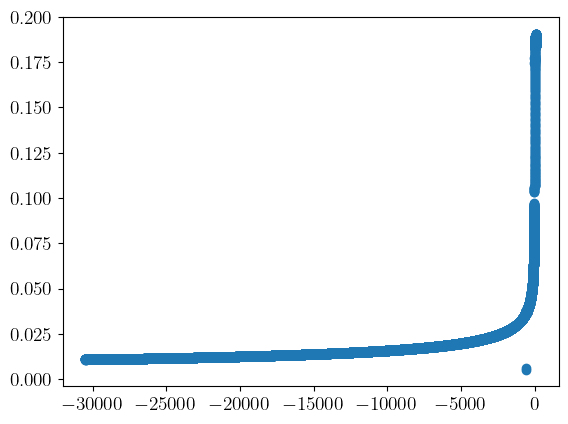

In [18]:
q=10
l=2
m=2

plt.plot(tNR_0PA(q),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q)),'o')

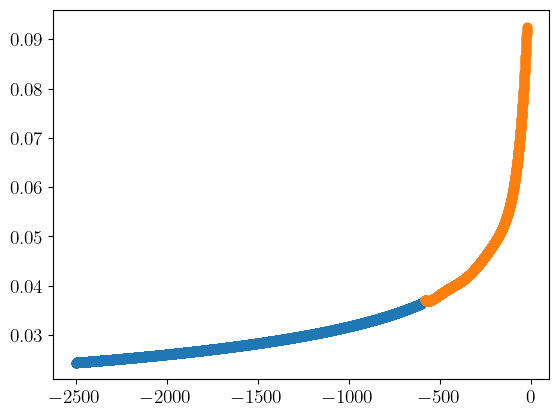

In [19]:
#Cleaning up the noise data, removing spikes that appear from finite differencing
#Need to truncate last few points
plt.plot(tNR_0PA(q)[140000:149500][:-2],omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q))[140000:149500][:-2],'o')
plt.plot(tNR_0PA(q)[149600:152400][:-2],omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA(q))[149600:152400][:-2],'o')

In [20]:
##Full data set takes too long to run
#plt.plot(tNR_scaled(q)[140000:153000],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[140000:153000]),'o')

In [21]:
#plt.plot(tNR_scaled(q)[140000:149450],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[140000:149450]),'o')
#plt.plot(tNR_scaled(q)[149650:152100],omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled(q)[149650:152100]),'o')

In [22]:
def tNR_0PA_new(q):
    return np.append(tNR_0PA(q)[130000:149500],tNR_0PA(q)[149600:152600]).flatten()

#def tNR_scaled_new(q):
#    return np.append(tNR_scaled(q)[140000:149450],tNR_scaled(q)[149650:152600]).flatten()

In [23]:
#Need to interpolate so can do finite difference again to calcaulte dOmega/dt
def omegaNR_secondorder_finitediff_0PA_interp(q,l,m,t):
    return interpolate.interp1d(tNR_0PA_new(q),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))(t)

#def omegaNR_secondorder_finitediff_scaled_interp(q,l,m,t):
#    return interpolate.interp1d(tNR_scaled_new(q),omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))(t)

In [24]:
#Check that frequency is monotonic in a region where we want to match the phases/times.

#q=...
#for i in range(len(tNR_scaled_new(q)[11000:])-1):
#    if omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q)[11000:])[i]>omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q)[11000:])[i+1]:
#        print('NOT MONOTONIC')
#        print(i)
#        print(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,tNR_scaled_new(q))[i])

## BHPTNRSur Frequency Evolution

In [25]:
#Second-order finite difference
#Applying filter to omega here doesn't seem to work well
#Defining time derivative of orbital frequency
#Function of time
function_dict['domegaNRdt_secondorder_finitediff_0PA'] = {}
def domegaNRdt_secondorder_finitediff_0PA(q,l,m,t):  
    if (q,l,m,tuple(t)) in function_dict['domegaNRdt_secondorder_finitediff_0PA']:
        return function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]   
    else:
        domegadt_0PA=np.zeros(len(t))
        for i in range(len(t)): 
            #if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.           
            if t[i]<=t[2]:
                domegadt_0PA[0]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i]])))/(t[i+1]-t[i])
            elif t[i]>=t[-2]:
                domegadt_0PA[-1]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i-1]])))/(t[i]-t[i-1])
            else:
                domegadt_0PA[i]=(omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_0PA_interp(q,l,m,np.array([t[i-1]])))/(t[i+1]-t[i-1])
        function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]=domegadt_0PA 
        return function_dict['domegaNRdt_secondorder_finitediff_0PA'][q,l,m,tuple(t)]

In [26]:
#second-order finite difference as a function of omega 
#function_dict['domegaNRdt_secondorder_finitediff_omega_0PA'] = {}
#def domegaNRdt_secondorder_finitediff_omega_0PA(q,l,m): #Call as f(q,l,m)(omega)
#    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_omega_0PA']:
#        return function_dict['domegaNRdt_secondorder_finitediff_omega_0PA'][q,l,m]
#    else:  
#        domegadt_omega_0PA=interpolate.interp1d(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))  
#        function_dict['domegaNRdt_secondorder_finitediff_omega_0PA'][q,l,m]=domegadt_omega_0PA  
#        return function_dict['domegaNRdt_secondorder_finitediff_omega_0PA'][q,l,m]
    
#second-order finite difference as a function of Deltaomega 
function_dict['domegaNRdt_secondorder_finitediff_Deltaomega_0PA'] = {}
def domegaNRdt_secondorder_finitediff_Deltaomega_0PA(q,l,m): #Call as f(q,l,m)(Deltaomega)
    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_Deltaomega_0PA']:
        return function_dict['domegaNRdt_secondorder_finitediff_Deltaomega_0PA'][q,l,m]
    else: 
        domegadt_omega_0PA=interpolate.interp1d((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))) 
        function_dict['domegaNRdt_secondorder_finitediff_Deltaomega_0PA'][q,l,m]=domegadt_omega_0PA  
        return function_dict['domegaNRdt_secondorder_finitediff_Deltaomega_0PA'][q,l,m]   

In [27]:
##second-order finite difference
##Applying savgol filter to omega here doesn't seem to work well
##Defining time derivative of orbital frequency
##Function of time

#function_dict['domegaNRdt_secondorder_finitediff_scaled'] = {}
#def domegaNRdt_secondorder_finitediff_scaled(q,l,m,t):
#    if (q,l,m,tuple(t)) in function_dict['domegaNRdt_secondorder_finitediff_scaled']:
#        return function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]
#    else:
#        delta=0.005
#        domegadt_scaled=np.zeros(len(t))
#        for i in range(len(t)):
            ##if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.         
#            if t[i]<=t[2]:
#                domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i]])))/(t[i+1]-t[i])
#            elif t[i]>=t[-2]:
#                domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i-1]])))/(t[i]-t[i-1])
#            else:
#                 domegadt_scaled[i]=(omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i+1]]))-omegaNR_secondorder_finitediff_scaled_interp(q,l,m,np.array([t[i-1]])))/(t[i+1]-t[i-1])
#        function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]=domegadt_scaled 
#        return function_dict['domegaNRdt_secondorder_finitediff_scaled'][q,l,m,tuple(t)]

In [28]:
##second-order finite difference as a function of Omega 

##function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'] = {}
#def domegaNRdt_secondorder_finitediff_Omega_scaled(q,l,m):#Function of Omega
#    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled']:
#        return function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]
#    else:
#        domegadt_Omega_scaled=interpolate.interp1d(omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)),domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
#        function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]=domegadt_Omega_scaled 
#        return function_dict['domegaNRdt_secondorder_finitediff_Omega_scaled'][q,l,m]
    
##second-order finite difference as a function of DeltaOmega 
#function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'] = {}
#def domegaNRdt_secondorder_finitediff_DeltaOmega_scaled(q,l,m): #Function of DeltaOmega
#    if (q,l,m) in function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled']:
#        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]
#    else:
#        domegadt_Omega_scaled=interpolate.interp1d((omegaNR_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q))-Omegai())/lam(q)**2,domegaNRdt_secondorder_finitediff_scaled(q,l,m,tNR_scaled_new(q)))
#        function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]=domegadt_Omega_scaled 
#        return function_dict['domegaNRdt_secondorder_finitediff_DeltaOmega_scaled'][q,l,m]   

# SXS Data

In [29]:
#sim = 19, 5, 17, 34 correspond to q = 1, 5, 10, 15
sxsSims=list(["SXS:BBH:0299","SXS:BBH:0298","SXS:BBH:0297","SXS:BBH:0166","SXS:BBH:0296","SXS:BBH:0056","SXS:BBH:0295","SXS:BBH:0167","SXS:BBH:0294","SXS:BBH:0259","SXS:BBH:0301","SXS:BBH:0302","SXS:BBH:0303","SXS:BBH:1132","SXS:BBH:1220","SXS:BBH:0181","SXS:BBH:1108","SXS:BBH:1107","SXS:BBH:0071","SXS:BBH:0180","SXS:BBH:0007","SXS:BBH:1166","SXS:BBH:2516"])
sxsSims_Box=list(['BBH_SKS_d15_q4.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q4.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q5.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q5.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q6.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q6.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q7.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q7.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q8.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q8.50_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q9.00_sA_0_0_0_sB_0_0_0','BBH_SKS_d15_q9.50_sA_0_0_0_sB_0_0_0'])

In [30]:
#NR data import paths:
def simvar(simpos):
    if simpos<len(sxsSims):
        return sxsSims[simpos][8:12]
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return sxsSims_Box[simpos-len(sxsSims)][12:17]

#Determine highest lev to include in file path. 
#Ensures use of highest resolution simulation if multiple simulations are available for the same parameters.
def highestlev(simpos):
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return [x[0] for x in os.walk(f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}")][-1][-1]
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return [x[0] for x in os.walk(f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0")][-1][-1]
            
#Meta data path:
def metapath(simpos):
    lev=highestlev(simpos)
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}\\Lev{lev}\\metadata.txt"
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0\\Lev{lev}\\metadata.txt"

    #Strain data path:
def strainpathNR(simpos):
    lev=highestlev(simpos)
    sim=str(simvar(simpos))
    if simpos<len(sxsSims):
        return f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SXS Data\\SXS_BBH_{sim}\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
    elif len(sxsSims)+len(sxsSims_Box)>simpos>=len(sxsSims):
        return f"{dir_Box}\\BBH_SKS_d15_{sim}_sA_0_0_0_sB_0_0_0\\Lev{lev}\\rhOverM_Asymptotic_GeometricUnits_CoM.h5"
        
#Gives name of simulation based on position in list of sxsSims:
def simname(simpos):
    return metapath(simpos)    

In [31]:
#NR data extraction from files:

function_dict['NR_data'] = {}

#Positions in lists below are chosen to extract relevant data from the rhOverM_Asymptotic_GeometricUnits_CoM.h5 files from the SXS catalogue.
def NRdatextraction(sim,N):
    if (sim,N) in function_dict['NR_data']:
        return function_dict['NR_data'][sim,N]
    else:
        straindat=h5py.File(strainpathNR(sim),'r')
        Ndat=list(straindat.keys())[N-2]
        Yl2m2dat=list(straindat[Ndat].keys())[2]
        h22dat=np.array(straindat[Ndat][Yl2m2dat])
    
        tvec=h22dat[:,0]
    
        ampvec=np.zeros(len(h22dat))
        phasevec=np.zeros(len(h22dat))
        h22vec=np.zeros(len(h22dat))
    
        for i in range(len(h22dat)):
            ampvec[i]=abs(h22dat[i][1]-1j*h22dat[i][2])
            phasevec[i]=cmath.phase(complex(h22dat[i][1],-h22dat[i][2]))
            h22vec[i]=np.real(ampvec[i]*np.e**complex(0,phasevec[i]))
    
        function_dict['NR_data'][sim,N]=np.array([tvec, ampvec, phasevec, h22vec])
        return  function_dict['NR_data'][sim,N]

#Raw NR strain, amplitudes and phase from NR data:
def tNR(sim,N):
    return NRdatextraction(sim,N)[0]

def ampNR(sim,N):
    return NRdatextraction(sim,N)[1]

#GW phase (not orbital phase)
def phaseNR(sim,N):
    return NRdatextraction(sim,N)[2]

def strainNR(sim,N):
    return NRdatextraction(sim,N)[3]

#Interpolated strain, amplitudes and phase from NR data:
def strainNRinterp(sim,N,t):
    return interpolate.interp1d(tNR(sim,N),strainNR(sim,N),kind='cubic')(t)

def ampNRinterp(sim,N,t):
    return interpolate.interp1d(tNR(sim,N),ampNR(sim,N),kind='cubic')(t)

def phaseNRinterp(sim,N,t): #Note that this is not the accumulated phase
    return interpolate.interp1d(tNR(sim,N),phaseNR(sim,N),kind='cubic')(t)

In [32]:
#Extracting metadata from matadata.txt files from SXS catalogue:
#Parameters are given at reference time after junk radiation.

#Find position of a string in a text file:
def stringpos(string,substring):
    position=string.find(substring)
    return position, position+len(substring)

#Positions in lists below are chosen to extract relevant data from the metadata.txt files from the SXS catalogue.
function_dict['NR_metadata'] = {}
def metadata(sim):
    if sim in function_dict['NR_metadata']:
        return function_dict['NR_metadata'][sim]
    else:
        metadatafile=open(metapath(sim),'r')
        content=metadatafile.read()
        
        if sim<len(sxsSims) or sim>31: 
            posstring=stringpos(content,'Quantities at reference time')
            contentslab=content[posstring[0]::]
    
            posstringt0=stringpos(contentslab,'reference-time = ')
            posstringOmega0=stringpos(contentslab,'reference-orbital-frequency = ')
            posstringm1=stringpos(contentslab,'reference-mass1    = ')
            posstringm2=stringpos(contentslab,'reference-mass2    = ')
            posstringcommonhorizon=stringpos(contentslab,'common-horizon-time')
        
        elif 31>=sim>=len(sxsSims): 
            posstring=stringpos(content,'Relaxed quantities')
            contentslab=content[posstring[0]::]
    
            posstringt0=stringpos(contentslab,'relaxed-measurement-time = ')
            posstringOmega0=stringpos(contentslab,'relaxed-orbital-frequency = ')
            posstringm1=stringpos(contentslab,'relaxed-mass1    = ')
            posstringm2=stringpos(contentslab,'relaxed-mass2    = ')
            posstringcommonhorizon=stringpos(contentslab,'common-horizon-time')
            
        #position of spaces, commas etc. are based on formatting of NR metadata.txt files.
        positiont0blank=contentslab[posstringt0[-1]::].find(' ')
        positionOmega0blanknew=posstringOmega0[-1]+contentslab[posstringOmega0[-1]::].find(', ')+2
        positionOmega0blanknew2=positionOmega0blanknew+contentslab[positionOmega0blanknew::].find(', ')+2
        positionOmega0blanknew3=positionOmega0blanknew2+contentslab[positionOmega0blanknew2::].find('#')
        positionm1blank=contentslab[posstringm1[-1]::].find('r')
        positionm2blank=contentslab[posstringm2[-1]::].find(' ')
        positioncommonhorizonblank=contentslab[posstringcommonhorizon[-1]::].find('\n')
        
        function_dict['NR_metadata'][sim]=np.array([float(contentslab[posstringt0[-1]:posstringt0[-1]+positiont0blank-1]),float(contentslab[positionOmega0blanknew2:positionOmega0blanknew3]),float(contentslab[posstringm1[-1]:posstringm1[-1]+positionm1blank-1]),float(contentslab[posstringm2[-1]:posstringm2[-1]+positionm2blank-1]),float(contentslab[posstringcommonhorizon[-1]+4:posstringcommonhorizon[-1]+positioncommonhorizonblank])])
        return function_dict['NR_metadata'][sim]

In [33]:
#Defining metadata functions:

#Start time of simulation after junk radiation:
def t0NR(sim):
    return metadata(sim)[0]

#Initial orbital frequency of simulation after junk radiation:
def Omega0NR(sim):
    return metadata(sim)[1]

#Primary mass:
def m1NR(sim):
    return metadata(sim)[2]

#Secondary mass:
def m2NR(sim):
    return metadata(sim)[3]

#Total mass. #MNR is actually a function of time from horizon data. This will introduce some small error. May want to update this in future.
def MNR(sim): 
    return m1NR(sim)+m2NR(sim)

#Large mass ratio:
def qNR(sim):
    return m1NR(sim)/m2NR(sim)

#Initial orbital radius after junk radiation:
def r0NR(sim):
    return (MNR(sim)*Omega0NR(sim))**(-2/3)

#Horizon time:
def tHorNR(sim):
    return metadata(sim)[-1]

In [34]:
#Define functions for NR data to be shifted to times after junk radiation:

def tNR_afterjunk(sim,N):
    return tNR(sim,N)[position(t0NR(sim),tNR(sim,N))[0]:]

def tNR_afterjunk_tohorizon(sim):
    delta=0.001
    return np.linspace(t0NR(sim)+2*delta,tHorNR(sim),10000)

## SXS Phase

In [35]:
function_dict['NR_phase_unwrapped'] = {}
def unwrappedphase(sim,N): 
    if (sim,N) in function_dict['NR_phase_unwrapped']:
        return function_dict['NR_phase_unwrapped'][sim,N]
    else:
        function_dict['NR_phase_unwrapped'][sim,N]=-np.unwrap(phaseNR(sim,N))
        return function_dict['NR_phase_unwrapped'][sim,N]

function_dict['NR_phase_unwrapped_interp'] = {}
def unwrappedphaseinterp(sim,N): #Call as unwrappedphaseinterp(sim,N)(t)
    if (sim,N) in function_dict['NR_phase_unwrapped_interp']:
        return function_dict['NR_phase_unwrapped_interp'][sim,N]
    else:
        function_dict['NR_phase_unwrapped_interp'][sim,N]=interpolate.interp1d(tNR(sim,N),unwrappedphase(sim,N),kind='cubic')
        return function_dict['NR_phase_unwrapped_interp'][sim,N]

## SXS Frequency

In [36]:
#Use fourth-order finite difference method to calcualte orbital frequency from accumulated NR GW phase data. 
#Unwrappedphaseinterp is an interpolated cubic spline. No need to interpolate frequency.
function_dict['omegaNR_fourthorder_finitedifference'] = {}
def omegaNR_fourthorder_finitediff(sim,N,t): 
    if (sim,N,tuple(t)) in function_dict['omegaNR_fourthorder_finitedifference']:
        return function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]
    else:
        delta=0.001
        m=2 #Include factor of m to calcualte orbital frequency rather than GW frequency, to compare with GSF results.
        omega=np.zeros(len(t))
        for i in range(len(t)):
            if t[i]<tNR_afterjunk(sim,N)[1]: #Forward finite difference at start of vector
                omega[i]=(unwrappedphaseinterp(sim,N)(t[i]+delta)-unwrappedphaseinterp(sim,N)(t[i]))/(2*delta) 
            elif t[i]>tNR_afterjunk(sim,N)[-2]: #Backwards finite difference at end of vector
                omega[i]=(unwrappedphaseinterp(sim,N)(t[i])-unwrappedphaseinterp(sim,N)(t[i]-delta))/(2*delta)
            else: 
                 omega[i]=(-unwrappedphaseinterp(sim,N)(t[i]+2*delta)+8*unwrappedphaseinterp(sim,N)(t[i]+delta)-8*unwrappedphaseinterp(sim,N)(t[i]-delta)+unwrappedphaseinterp(sim,N)(t[i]-2*delta))/(12*2*delta)
        function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]=omega 
        return function_dict['omegaNR_fourthorder_finitedifference'][sim,N,tuple(t)]
        
function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'] = {}
def omegaNR_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N):
    if (order, window, omega_min,omega_max,sim,N) in function_dict['omegaNR_fourthorder_finitedifference_savgolfilter']:
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]
    else:
        function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]=savgol_filter(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)), window,order, deriv=0, delta=0.01, mode='interp')
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter'][order, window, omega_min,omega_max,sim,N]
    
#Need to interpolate if want to access omegaNR_fourthorder_finitediff_savgolfilter at a specific time t[i], or t[i]+delta. 
#Need to do this to obtain domegadt

function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'] = {}
def omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N):#Call as f(t) where t lies between tNR_afterjunk(sim,N)[omega_min_pos:omega_max_pos]
    if (order, window, omega_min,omega_max,sim,N) in function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp']:
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order,window,omega_min,omega_max,sim,N]
    else:
        function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order, window, omega_min,omega_max,sim,N]=interpolate.interp1d(tNR_afterjunk_tohorizon(sim),omegaNR_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N),kind='cubic')
        return function_dict['omegaNR_fourthorder_finitedifference_savgolfilter_interp'][order, window, omega_min,omega_max,sim,N]

In [37]:
#Check for duplicates. These cause problems when interpolating later on.
#for sim in range(4):
#    for i in range(len(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))-1):
#        if omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))[i]==omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))[i+1]:
#            print('has dupilate')
#            print(i)

## SXS Frequency Evolution

In [38]:
#Fourth-order finite difference
#Applying savgol filter to omega here doesn't seem to work well
#Defining time derivative of orbital frequency
#Function of time
function_dict['domegaNRdt_fourthorder_finitediff'] = {}
def domegaNRdt_fourthorder_finitediff(sim,N,t):
    if (sim,N,tuple(t)) in function_dict['domegaNRdt_fourthorder_finitediff']:
        return function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]
    else:
        delta=0.001
        domegadt=np.zeros(len(t))
        for i in range(len(t)):  
            ##if domegaNRdt=0, need to remove simulation as we will divide by domegaNRdt later on when defining Q, the inverse adiabaticity parameter.           
            if t[i]<tNR_afterjunk(sim,N)[1]:
                domegadt[0]=(omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+delta]))-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]])))/(delta)
            elif t[i]>tNR_afterjunk(sim,N)[-2]:
                domegadt[-1]=(omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]]))-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-delta])))/(delta)
            else:
                domegadt[i]=(-omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+2*delta]))+8*omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]+delta]))-8*omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-delta]))+omegaNR_fourthorder_finitediff(sim,N,np.array([t[i]-2*delta])))/(12*delta)
        function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]=domegadt 
        return function_dict['domegaNRdt_fourthorder_finitediff'][sim,N,tuple(t)]
    
##Fourth-order finite difference as a function of omega 
#function_dict['domegaNRdt_fourthorder_finitediff_omega'] = {}
#def domegaNRdt_fourthorder_finitediff_omega(sim,N):#Function of omega
#    if (sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_omega']:
#        return function_dict['domegaNRdt_fourthorder_finitediff_omega'][sim,N]
#    else: 
#        domegadt_omega=interpolate.interp1d(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
#        function_dict['domegaNRdt_fourthorder_finitediff_omega'][sim,N]=domegadt_omega 
#        return function_dict['domegaNRdt_fourthorder_finitediff_omega'][sim,N]

#Fourth-order finite difference as a function of Deltaomega
function_dict['domegaNRdt_fourthorder_finitediff_Deltaomega'] = {}
def domegaNRdt_fourthorder_finitediff_Deltaomega(sim,N):#Function of Deltaomega
    if (sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_Deltaomega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_Deltaomega'][sim,N]
    else: 
        domegadt_Omega=interpolate.interp1d((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))-Omegai())/(nu(qNR(sim))**(2/5)),domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))
        function_dict['domegaNRdt_fourthorder_finitediff_Deltaomega'][sim,N]=domegadt_Omega  
        return function_dict['domegaNRdt_fourthorder_finitediff_Deltaomega'][sim,N]   

In [39]:
#Function of time with savgol filter applied to domegadt
#function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'] = {}
#def domegaNRdt_fourthorder_finitediff_savgolfilter(order,window,omega_min,omega_max,sim,N):
#    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter']:
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]
#    else:
#        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),window,order,deriv=0, delta=0.05, mode='interp')
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter'][order,window,omega_min,omega_max,sim,N]
    
##Function of omega with savgol filter applied to domegadt
#function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_omega'] = {}
#def domegaNRdt_fourthorder_finitediff_savgolfilter_omega(order,window,omega_min,omega_max,sim,N):
#    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_omega']:
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_omega'][order,window,omega_min,omega_max,sim,N]
#    else:
#        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_omega'][order,window,omega_min,omega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff_omega(sim,N)(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))),window,order,deriv=0, delta=0.05, mode='interp')
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_omega'][order,window,omega_min,omega_max,sim,N]
                                                                                                                                    
#Function of Deltaomega with savgol filter applied to domegadt
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega'] = {}
def domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N):
    if (order,window,deltaomega_min,deltaomega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]
    else:        
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]=savgol_filter(domegaNRdt_fourthorder_finitediff_Deltaomega(sim,N)(((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))-Omegai())/(nu(qNR(sim))**(2/5))),window,order,deriv=0, delta=0.01, mode='interp')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]                                                                                                                                 

In [40]:
##Function of omega with savgol filter applied to domegadt interpolated
#function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega'] = {}
#def domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega(order,window,omega_min,omega_max,sim,N):
#    if (order,window,omega_min,omega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega']:
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega'][order,window,omega_min,omega_max,sim,N]
#    else:
#        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega'][order,window,omega_min,omega_max,sim,N]=interpolate.interp1d(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),domegaNRdt_fourthorder_finitediff_savgolfilter_omega(order,window,omega_min,omega_max,sim,N),kind='cubic')
#        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_omega'][order,window,omega_min,omega_max,sim,N]  

#Function of Deltaomega with savgol filter applied to domegadt interpolated
function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega'] = {}
def domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N):
    if (order,window,deltaomega_min,deltaomega_max,sim,N) in function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega']:
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]
    else:        
        function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]=interpolate.interp1d((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))-Omegai())/(nu(qNR(sim))**(2/5)),domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N),kind='cubic')
        return function_dict['domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega'][order,window,deltaomega_min,deltaomega_max,sim,N]                                                                                                                                 

# GSF Data

## Amplitudes (Part I)

In [41]:
#Some information of the amplitudes (H5 and H7) are required as input for the frequency evolution when reexpanded in terms of the NR frequency.
#The full 0PLT/2PLT amplitude depends on the 0PLT/2PLT frequency however.
#We will revisit the GSF amplitudes in full when the 0PLT/2PLT orbital frequencies have been solved.

In [42]:
#Data for Psi4 extracted at infinity
#File returns radial grid, and real and imaginary parts of first-order data for Psi4.

function_dict['GSF_dat']={}
def Psi4_inf_path(l,m):
    dir=os.getcwd() 
    return f"C:\\Users\\Leanne Durkan\\Documents\\LEANNES_STUFF\\Postdoc Austin\\NR and SMR Comparisons\\Schwarzschild\\SMR inspiral Data\\Psi4inf Data\\Zinf{l}{m}.h5"
    
function_dict['GSF_dat']['psi4']={}
def Psi4_inf_dat(l,m):
    
    if (l,m) in function_dict['GSF_dat']['psi4']:
        return function_dict['GSF_dat']['psi4'][l,m]
    else:
        tmp1=h5py.File(Psi4_inf_path(l,m),'r')
        r0vec1=np.array(tmp1[list(tmp1.keys())[2]])
        ReZinf=np.array(tmp1[list(tmp1.keys())[1]])
        ImZinf=np.array(tmp1[list(tmp1.keys())[0]])
        function_dict['GSF_dat']['psi4'][l,m]=np.array([r0vec1, ReZinf, ImZinf])
    return function_dict['GSF_dat']['psi4'][l,m]

#Radial grid on which first-order data is calcaulted
def r0grid(l,m):
    return Psi4_inf_dat(l,m)[0]

#Real part of first-order data for Psi4
function_dict['GSF_dat']['RePsi4_interp']={}
def RePsi4_inf(l,m): #Call as f(l,m)(r0)
    if (l,m) in function_dict['GSF_dat']['RePsi4_interp']:
        return function_dict['GSF_dat']['RePsi4_interp'][l,m]
    else:
        function_dict['GSF_dat']['RePsi4_interp'][l,m]=interpolate.interp1d(r0grid(l,m),Psi4_inf_dat(l,m)[1], kind='cubic')
        return function_dict['GSF_dat']['RePsi4_interp'][l,m]

#Imaginary part of first-order data for Psi4
function_dict['GSF_dat']['ImPsi4_interp']={}
def ImPsi4_inf(l,m): #Call as Impsi4inf(l,m)(r0)
    if (l,m) in function_dict['GSF_dat']['ImPsi4_interp']:
        return function_dict['GSF_dat']['ImPsi4_interp'][l,m]
    else:
        function_dict['GSF_dat']['ImPsi4_interp'][l,m]=interpolate.interp1d(r0grid(l,m),Psi4_inf_dat(l,m)[2], kind='cubic')
        return function_dict['GSF_dat']['ImPsi4_interp'][l,m]

#0PA Amplitude definition
def h_0PA(l,m,r0):
    if np.mod(m,2)==0:
        return (-2)*(RePsi4_inf(l,m)(r0))*r0**3/(m**2)+1j*(-2)*(ImPsi4_inf(l,m)(r0))*r0**3/(m**2)

def dr0dOmegai():
    M=1
    return -24*(6**(1/2))*M 

In [43]:
def H5(l,m):
    return h_0PA(l,m,6)

def H7(l,m):
    delta=0.001
    return dr0dOmegai()*(h_0PA(l,m,6+delta)-h_0PA(l,m,6))/delta #One sided finite difference as we need derivative at end point of data.

## Frequency and Phase Evolution during the transition to plunge (transition-only dynamics, not including inspiral motion)

In [44]:
#Values of first order energy flux at infinity and its derivative with respect to the leading order radius for circular orbit at the ISCO. 
flux1i=0.000940339356315095200 
dflux1idr0=-0.000892028880193301200

#t component of self-force at the ISCO:
ft1i=-(3/(2**(1/2)))*flux1i #3/4

#t component of omega derivative of self-force at the ISCO:
dft1idomega=12*(3**(1/2))*(-flux1i+6*dflux1idr0)

In [45]:
#Boundary conditions for X0 and X2 at early times.
#Note that tmin and tmax are not physical times, but the 'times' at which we can solve for X0 and X2 in the transition regime, from the early to late transition to appropriatley capture the desired dynamics.

def X0early(t):
    return -23167355502936795986195010/t**51 - 10223331600760441482825/t**46 - 5628415395384607293/t**41 - 3972772364116824/t**36 - 3722335794387/t**31 - 4846966614/t**26 -9346005/t**21 - 29349/t**16 - 177/t**11 - 3/t**6 - 1/t

def X0earlyprime(t):
    return 1181535130649776595295945510/t**52 + 470273253634980308209950/t**47 +230765031210768899013/t**42 + 143019805108205664/t**37 + 115392409625997/t**32 + 126021131964/t**27 + 196266105/t**22 + 469584/t**17 + 1947/t**12 + 18/t**7 + 1/t**2

def X2early(t):
    return -1.5890575399847129 - 162325.4772006709/t**15 - 702.5772748928009/t**10 - 7.382561487961286/t**5 #-1.24338856914683318262945630044 -123573.898042321183276235978732/t**15 -538.14669953365742657341937005/t**10 -5.7270612249289095272197379651/t**5

def X2earlyprime(t):
    return 2.434882158010063*1e6/t**16 + 7025.77274892801/t**11 + 36.91280743980643/t**6 #1.8536084706348177491435396810*10**6/t**16 + 5381.4669953365742657341937005/t**11 + 28.635306124644547636098689826/t**6

In [46]:
#Coupled differential equations for orbital phase and orbital frequency evolution: 
#y[0]=X0,y[1]=dX0dt,y[2]=X2,y[3]=dX2dt. 
#X0 and X2 (y[0] and y[2]) are rescaled leading and next-to leading-order forcing terms during the inspiral, which determine the frequency evolution.
#The second and final element of the array below are expressions for X0'' and X2''.

def transitionfrequencyevolution0PA(t,y): #Independent of mass ratio.
    M=1
    return np.array([y[1],1/y[0]**2-(y[1]**2)/y[0]+t/y[0],y[3],((3)**(1/10))*dft1idomega*(((ft1i**2)/M**3)**(1/5))*t/(2*(2**(1/2))*ft1i*y[0]**2)+2*(3**(3/5))*(((-ft1i*M)**(2/5))*t/(y[0]**2))+11*((3)**(3/5))*((-ft1i*M)**(2/5))*(t**2)/(2*y[0])-2*y[2]/(y[0]**3)-t*y[2]/(y[0]**2)+13*(3**(3/5))*((-ft1i*M)**(2/5))*y[1]+y[2]*(y[1]**2)/y[0]**2-2*y[1]*y[3]/y[0]])

In [47]:
#Solving for X0 and X2.

function_dict['transition_frequency']={}

function_dict['transition_frequency']['t']={}
function_dict['transition_frequency']['X0']={}
function_dict['transition_frequency']['X2']={}

tmin=-20 
tmax=30
tspan=np.linspace(tmin,tmax,10000)
yinit=np.array([X0early(tmin),X0earlyprime(tmin),X2early(tmin),X2earlyprime(tmin)])

def transitionfrequencysolution0PA():
    if len(function_dict['transition_frequency']['t'])!=0:
        return function_dict['transition_frequency']['t'], function_dict['transition_frequency']['X0'], function_dict['transition_frequency']['X2']
    else:
        sol= solve_ivp(lambda t, y: transitionfrequencyevolution0PA(t,y), [tmin,tmax], yinit, teval=tspan, method='RK45', rtol=5e-14, dense_output=True)
        function_dict['transition_frequency']['t']=sol.t
        function_dict['transition_frequency']['X0']=sol.y[0]
        function_dict['transition_frequency']['X2']=sol.y[2]
        return function_dict['transition_frequency']['t'], function_dict['transition_frequency']['X0'], function_dict['transition_frequency']['X2']
    
function_dict['X0']={}
def X0(t):
    if (tuple(t)) in function_dict['X0']:
        return function_dict['X0'][tuple(t)]
    else:
        function_dict['X0'][tuple(t)] = interpolate.interp1d(transitionfrequencysolution0PA()[0],transitionfrequencysolution0PA()[1],kind='cubic')(t)
        return function_dict['X0'][tuple(t)]
    
function_dict['X2']={}
def X2(t):
    if (tuple(t)) in function_dict['X2']:
        return function_dict['X2'][tuple(t)]
    else:
        function_dict['X2'][tuple(t)]=interpolate.interp1d(transitionfrequencysolution0PA()[0],transitionfrequencysolution0PA()[2],kind='cubic')(t)
        return function_dict['X2'][tuple(t)]

In [48]:
#DeltaOmega=(Omega-Omegai)/lam(sim).
#alpha and beta are rescaling factors to convert X0 and X2 back to FdeltaOmega0 and FdeltaOmega2.

def alpha_fun(): #alpha is defined in Python as plot transparency. Use alpha_fun instead.
    M=1
    return -ft1i/(2*24*9*((6)**(1/2))*M**3)

def beta():
    M=1
    return 1/(9*((6)**(1/2))*M)

#Forcing terms as a function of Omega
def FdeltaOmega0_Omega(Omega,q,massratiotype):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X0((alpha_fun()**(-2/5))*(beta()**(3/5))*(Omega-Omegai())/(massratiotype(q)**(2/5)))

def FdeltaOmega2_Omega(Omega,q,massratiotype):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X2(((alpha_fun())**(-2/5))*(beta()**(3/5))*(Omega-Omegai())/(massratiotype(q)**(2/5)))

#Forcing terms are independent of mass ratio when written in terms of DeltaOmega
#Forcing terms as a function of DeltaOmega
def FdeltaOmega0_DeltaOmega(DeltaOmega):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X0(((alpha_fun())**(-2/5))*(beta()**(3/5))*DeltaOmega)

def FdeltaOmega2_DeltaOmega(DeltaOmega):
    return (alpha_fun()**(3/5))*(beta()**(-2/5))*X2(((alpha_fun())**(-2/5))*(beta()**(3/5))*DeltaOmega)

In [49]:
#For re-expansion in terms of NR frequency for accuracte comparisons with NR
#Due to the small oscillations, finite differencing method is preferable to UnivariateSpline or CubicSpline

#Functions of Omega for comparisons with phase and amplitudes
def dFdeltaOmega0dDeltaOmega_Omega(Omega,q,massratiotype):
    delta=0.001
    return (massratiotype(q)**(2/5))*(FdeltaOmega0_Omega(Omega+delta,q,massratiotype)-FdeltaOmega0_Omega(Omega-delta,q,massratiotype))/(2*delta)
                                                                                                 
def d2FdeltaOmega0dDeltaOmega2_Omega(Omega,q,massratiotype):
    delta=0.001
    return (massratiotype(q)**(2/5))*(dFdeltaOmega0dDeltaOmega_Omega(Omega+delta,q,massratiotype)-dFdeltaOmega0dDeltaOmega_Omega(Omega-delta,q,massratiotype))/(2*delta)

#Functions of DeltaOmega for comparisons of dDeltaOmegadt
def dFdeltaOmega0dDeltaOmega_DeltaOmega(DeltaOmega):
    delta=0.001
    return (FdeltaOmega0_DeltaOmega(DeltaOmega+delta)-FdeltaOmega0_DeltaOmega(DeltaOmega-delta))/(2*delta)
                                                                                                 
def d2FdeltaOmega0dDeltaOmega2_DeltaOmega(DeltaOmega):
    delta=0.001
    return (dFdeltaOmega0dDeltaOmega_DeltaOmega(DeltaOmega+delta)-dFdeltaOmega0dDeltaOmega_DeltaOmega(DeltaOmega-delta))/(2*delta)

In [50]:
#DeltaOmega_min=-tmin*((alpha_fun())**(2/5))*(beta()**(-3/5))
#DeltaOmega_max=tmax*((alpha_fun())**(2/5))*(beta()**(-3/5))

#Omega_min=(nu(15)**(2/5))*(30*((alpha_fun())**(2/5))*(beta()**(-3/5))+Omegai())
#Omega_max=(nu(1)**(2/5))*(30*((alpha_fun())**(2/5))*(beta()**(-3/5))+Omegai())

In [51]:
#Transition only, no inspiral contribution.
#Functions of Omega for phase and amplitude comparisons.
#Note the difference between Omega and omega.
#Note that dOmegadt is equivalent to domegadt at 0PLT order.

def dDeltaOmegadt_0PLT_Omega(Omega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_Omega(Omega,q,massratiotype)

def dDeltaOmegadt_2PLT_Omega(Omega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_Omega(Omega,q,massratiotype)+(massratiotype(q)**(3/5))*FdeltaOmega2_Omega(Omega,q,massratiotype)

def dDeltaomegadt_2PLT_reexpanded_omega(l,m,omega,q,massratiotype): 
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_Omega(omega,q,massratiotype)+(massratiotype(q)**(3/5))*FdeltaOmega2_Omega(omega,q,massratiotype)+(massratiotype(q)**(3/5))*((np.imag(H7(l,m))*np.real(H5(l,m))-np.imag(H5(l,m))*np.real(H7(l,m)))*FdeltaOmega0_Omega(omega,q,massratiotype)*d2FdeltaOmega0dDeltaOmega2_Omega(omega,q,massratiotype))

def dDeltaOmegadt_0PLT_Omega_interp(Omega,q,massratiotype): #Reexpanding in terms of NR frequency is the same at leading order
    return interpolate.interp1d(Omega_vec(q,massratiotype),dDeltaOmegadt_0PLT_Omega(Omega_vec(q,massratiotype),q,massratiotype),kind='cubic')(Omega)

def dDeltaOmegadt_2PLT_Omega_interp(Omega,q,massratiotype):
    return interpolate.interp1d(Omega_vec(q,massratiotype),dDeltaOmegadt_2PLT_Omega(Omega_vec(q,massratiotype),q,massratiotype),kind='cubic')(Omega)

def dDeltaomegadt_2PLT_reexpanded_omega_interp(l,m,omega,q,massratiotype):
    #Note that while Omega_vec was defined for Omega, we can use it in the interpolant for omega as well. 
    return interpolate.interp1d(Omega_vec(q,massratiotype),dDeltaomegadt_2PLT_reexpanded_omega(l,m,Omega_vec(q,massratiotype),q,massratiotype),kind='cubic')(omega)

In [52]:
#Transition only, no inspiral contribution.
#Functions of DeltaOmega. For dDeltaOmega/dt comparisons.
#Note the difference between Omega and omega.
#Note that dDeltaOmegadt is equivalent to dDeltaomegadt at 0PLT order.

def dDeltaOmegadt_0PLT_DeltaOmega(DeltaOmega,q,massratiotype): #Reexpanding in terms of NR frequency is the same at leading order
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_DeltaOmega(DeltaOmega)

def dDeltaOmegadt_2PLT_DeltaOmega(DeltaOmega,q,massratiotype):
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_DeltaOmega(DeltaOmega)+(massratiotype(q)**(3/5))*FdeltaOmega2_DeltaOmega(DeltaOmega)

def dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,Deltaomega,q,massratiotype): #Contains additional terms when reexpanded in terms of NR frequency
    return ((massratiotype(q))**(1/5))*FdeltaOmega0_DeltaOmega(Deltaomega)+(massratiotype(q)**(3/5))*FdeltaOmega2_DeltaOmega(Deltaomega)+(massratiotype(q)**(3/5))*(-(((np.imag(H7(l,m))*np.real(H5(l,m))-np.imag(H5(l,m))*np.real(H7(l,m)))**2)/(8*(np.real(H5(l,m))**2+np.imag(H5(l,m))**2)**2))*(FdeltaOmega0_DeltaOmega(Deltaomega)**2)*d2FdeltaOmega0dDeltaOmega2_DeltaOmega(Deltaomega))

def dDeltaOmegadt_0PLT_DeltaOmega_interp(DeltaOmega,q,massratiotype):
    return interpolate.interp1d(DeltaOmega_vec(q,massratiotype),dDeltaOmegadt_0PLT_DeltaOmega(DeltaOmega_vec(q,massratiotype),q,massratiotype),kind='cubic')(DeltaOmega) 

def dDeltaOmegadt_2PLT_DeltaOmega_interp(DeltaOmega,q,massratiotype):
    return interpolate.interp1d(DeltaOmega_vec(q,massratiotype),dDeltaOmegadt_2PLT_DeltaOmega(DeltaOmega_vec(q,massratiotype),q,massratiotype),kind='cubic')(DeltaOmega)

def dDeltaomegadt_2PLT_Deltaomega_reexpanded_interp(l,m,Deltaomega,q,massratiotype):
    #Note that while Omega_vec was defined for Omega, we can use it in the interpolant for omega as well.
    return interpolate.interp1d(DeltaOmega_vec(q,massratiotype),dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,DeltaOmega_vec(q,massratiotype),q,massratiotype),kind='cubic')(Deltaomega)

# Comparing GSF, SXS and BHPTNRSur frequency evolution

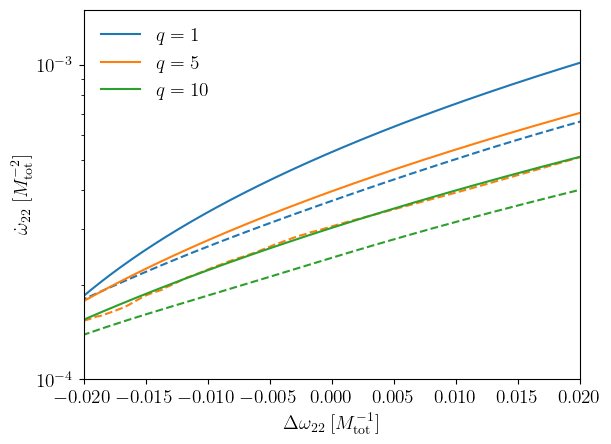

In [156]:
#Use symmetric mass ratio for SXS and GSF comparisons

deltaomega_min=-0.05
deltaomega_max=0.25

order=6
window=101

l=2
m=2

for sim in np.array([19,5,17]): #q=1,5,10
  
    if sim==19:
        colour='C0'
    elif sim==5:
        colour='C1'
    elif sim==17:
        colour='C2'
        
    omega_min=(nu(qNR(sim))**(2/5))*deltaomega_min+Omegai()
    omega_max=(nu(qNR(sim))**(2/5))*deltaomega_max+Omegai()
    
    #Here we consider DeltaOmega_vec as Deltaomega_vec
    plt.plot(DeltaOmega_vec(qNR(sim),nu),(nu(qNR(sim))**(2/5))*dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,DeltaOmega_vec(qNR(sim),nu),qNR(sim),nu),color=colour,label='$q=%.0f$'%qNR(sim))
    plt.plot((omegaNR_fourthorder_finitediff_savgolfilter_interp(order,window,omega_min,omega_max,sim,N)(tNR_afterjunk_tohorizon(sim))-Omegai())/(nu(qNR(sim))**(2/5)),domegaNRdt_fourthorder_finitediff_savgolfilter_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N),color=colour, ls='--')

plt.xlim(-0.02,0.02)
plt.ylim(0.0001,0.0015)
plt.yscale('log')

plt.ylabel('$ \dot{\omega}_{22} ~[M_{\mathrm{tot}}^{-2}]$ ')
plt.xlabel('$\Delta\omega_{22} ~[M^{-1}_{\mathrm{tot}}]$')
plt.legend(loc='upper left', frameon=False)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig(f'Final Figures/domegadt_Deltaomega_SXSsimsvGSF_nearISCO.png',bbox_inches='tight', dpi=300)

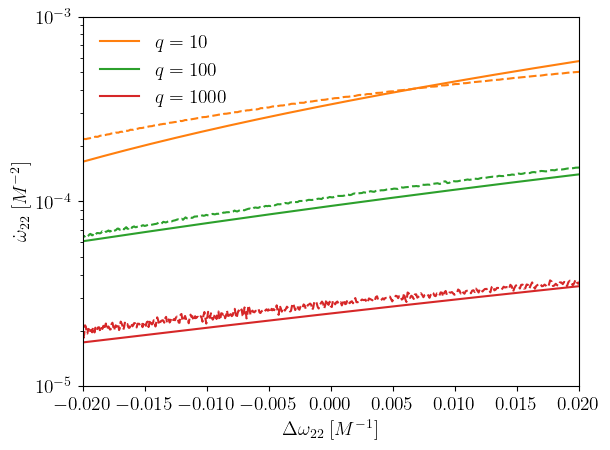

In [155]:
#Use small mass ratio for BHPTNRSur and GSF comparisons. Compare 2PLT with 0PA (unscaled) surrogate.
#This step takes a few minutes

for q in np.array([10,100,1000]):
  
    if q==10:
        colour='C1'
    elif q==100:
        colour='C2'
    elif q==1000:
        colour='C3'
        
    #Here we consider DeltaOmega_vec as Deltaomega_vec
    #Cannot use DeltaOmega_vec for very high q, as the frequencies go out of range of the interpolation function for dDeltaomegadt
    plt.plot(np.linspace(-0.02,0.02,1000),(eps(q)**(2/5))*dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,np.linspace(-0.02,0.02,1000),q,eps),color=colour,label='$q=%.0f$'%q)
    plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/(eps(q)**(2/5)),domegaNRdt_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),color=colour,ls='--')

plt.xlim(-0.02,0.02)
plt.ylim(0.00001,0.001)
plt.yscale('log')

plt.ylabel('$\dot{\omega}_{22} ~[M^{-2}]$')
plt.xlabel('$\Delta\omega_{22} ~[M^{-1}]$')
plt.legend(loc='upper left', frameon=False)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig(f'Final Figures/domegadt_Deltaomega_BHPTNRSur_UncalibratedvGSF_nearISCO.png',bbox_inches='tight', dpi=300)

# Residual of frequency evolution between SXS and 2PLT

Text(0.5, 0, '$\\nu$')

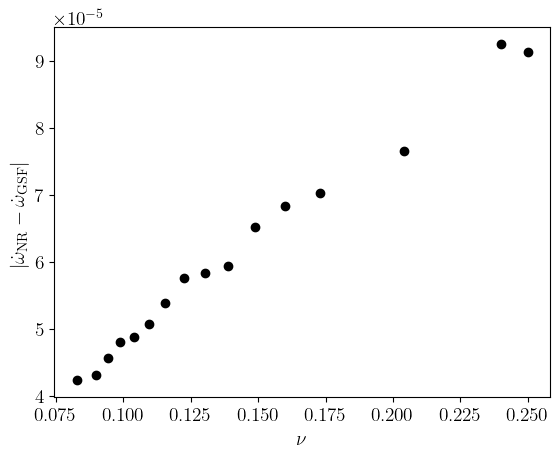

In [55]:
deltaomega_min=-0.05
deltaomega_max=0.25

order=6
window=101

l=2
m=2

fixed_deltaomega=-0.008

for sim in np.array([19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17]):
    plt.plot(nu(qNR(sim)),(nu(qNR(sim))**(2/5))*dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,np.array([fixed_deltaomega]),qNR(sim),nu)-domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N)(fixed_deltaomega),'o', color='black')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel('$|\dot{\omega}_{\mathrm{NR}}-\dot{\omega}_{\mathrm{GSF}}|$')
plt.xlabel('$\\nu$')

In [56]:
fixed_deltaomega=-0.008
resdomegadt_vec=[None]*16
domegadtNR_vec=[None]*16
domegadt0PLT_vec=[None]*16
domegadt2PLT_vec=[None]*16

#Note the different uses of DeltaOmega and Deltaomega. At 0PLT order, DeltaOmega and Deltaomega are equivalent.

for sim in np.array([19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17]):
    resdomegadt_vec[[19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17].index(sim)]=(nu(qNR(sim))**(2/5))*dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,np.array([fixed_deltaomega]),qNR(sim),nu)[0]-domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N)(fixed_deltaomega)
    domegadtNR_vec[[19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17].index(sim)]=domegaNRdt_fourthorder_finitediff_savgolfilter_interp_Deltaomega(order,window,deltaomega_min,deltaomega_max,sim,N)(fixed_deltaomega)
    domegadt0PLT_vec[[19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17].index(sim)]=(nu(qNR(sim))**(2/5))*dDeltaOmegadt_0PLT_DeltaOmega(np.array([fixed_deltaomega]),qNR(sim),nu)[0]
    domegadt2PLT_vec[[19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17].index(sim)]=(nu(qNR(sim))**(2/5))*dDeltaomegadt_2PLT_reexpanded_Deltaomega(l,m,np.array([fixed_deltaomega]),qNR(sim),nu)[0]
    
nu_vec_true=[None]*16
for sim in np.array([19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17]):
    nu_vec_true[[19, 20, 9, 8, 14, 24, 5, 26, 15, 28, 29, 30, 31, 32, 33, 17].index(sim)]=nu(qNR(sim))

#Can also see how results change when using: nu_vec=np.linspace(0,0.25,17)
resdomegadt_interp=interpolate.interp1d(nu_vec_true,np.array(resdomegadt_vec))
domegadtNR_interp=interpolate.interp1d(nu_vec_true,domegadtNR_vec)
domegadt0PLT_interp=interpolate.interp1d(nu_vec_true,domegadt0PLT_vec)
domegadt2PLT_interp=interpolate.interp1d(nu_vec_true,domegadt2PLT_vec)

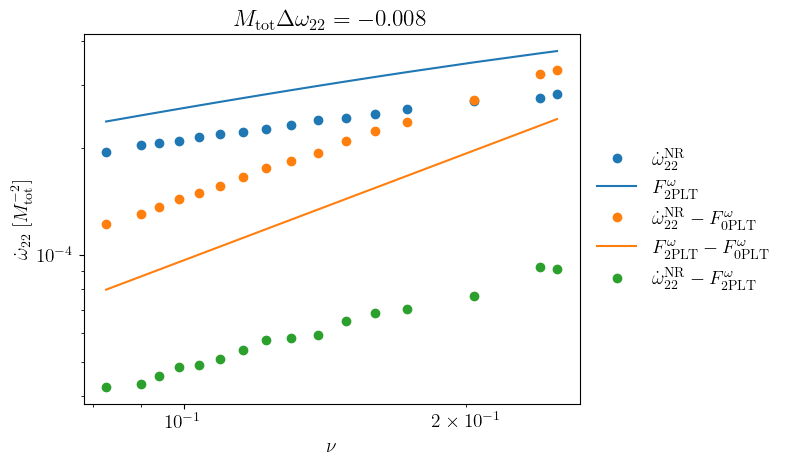

In [57]:
plt.loglog(nu_vec_true,domegadtNR_interp(nu_vec_true),'o',label='$\dot{\omega}^{\mathrm{NR}}_{22}$',color='C0')
plt.loglog(nu_vec_true,domegadt2PLT_interp(nu_vec_true),label='$F^{\omega}_{\mathrm{2PLT}}$',color='C0')
plt.loglog(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),'o',label='$\dot{\omega}^{\mathrm{NR}}_{22}-F^{\omega}_{\mathrm{0PLT}}$',color='C1')
plt.loglog(nu_vec_true,np.abs(domegadt2PLT_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),label='$F^{\omega}_{\mathrm{2PLT}}-F^{\omega}_{\mathrm{0PLT}}$',color='C1')
plt.loglog(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt2PLT_interp(nu_vec_true)),'o',label='$\dot{\omega}^{\mathrm{NR}}_{22}-F^{\omega}_{\mathrm{2PLT}}$',color='C2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\omega}_{22} ~ [M_{\mathrm{tot}}^{-2}]$')
plt.title('$M_{\mathrm{tot}} \Delta\omega_{22}=%.3f$'%fixed_deltaomega)

plt.savefig(f'Final Figures/domegadt_scaling_SXSvGSF.png',bbox_inches='tight', dpi=300)

In [58]:
#Export Data

#transition_data_path=f"{dir}\\transition_data.h5"
#transition_data_file = h5py.File(transition_data_path, 'w')

#transition_data_file.create_dataset('domegadtNR', data=domegadtNR_interp(nu_vec_true))
#transition_data_file.create_dataset('2PLT', data=domegadt2PLT_interp(nu_vec_true))
#transition_data_file.create_dataset('domegadtNR_minus_0PLT', data=np.abs(domegadtNR_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)))
#transition_data_file.create_dataset('domegadtNR_minus_2PLT', data=np.abs(domegadtNR_interp(nu_vec_true)-domegadt2PLT_interp(nu_vec_true)))
#transition_data_file.create_dataset('2PLT_minus_0PLT', data=np.abs(domegadt2PLT_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)))
#transition_data_file.create_dataset('nu_vec', data=nu_vec_true)

#transition_data_file.close()

#trans_dat=h5py.File('transition_data.h5','r')
#trans_dat.keys()

### Fitting the residual

In [59]:
def polynomial_free_2params(x,a,p1):
    return a*x**(p1)

Text(0.5, 1.0, '$\\Delta\\omega=-0.008/M_{\\mathrm{tot}}$')

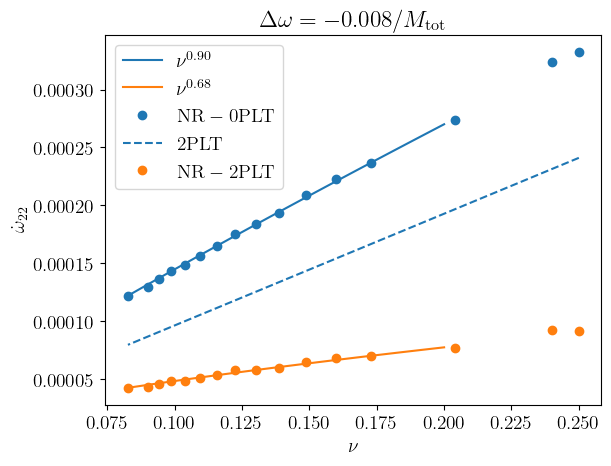

In [60]:
nu_vec_small=np.linspace(nu(qNR(17)),0.2,100)

coeffsNRm0PLT=curve_fit(polynomial_free_2params, nu_vec_small, np.abs(domegadtNR_interp(nu_vec_small)-domegadt0PLT_interp(nu_vec_small)), maxfev=5000)[0]
coeffsNRm0PLTm2PLT=curve_fit(polynomial_free_2params, nu_vec_small, np.abs(domegadtNR_interp(nu_vec_small)-domegadt2PLT_interp(nu_vec_small)), maxfev=5000)[0]

plt.plot(nu_vec_small,polynomial_free_2params(nu_vec_small,*coeffsNRm0PLT),label='$\\nu^{%.2f}$'%coeffsNRm0PLT[1],color='C0')
plt.plot(nu_vec_small,polynomial_free_2params(nu_vec_small,*coeffsNRm0PLTm2PLT),label='$\\nu^{%.2f}$'%coeffsNRm0PLTm2PLT[1],color='C1')

plt.plot(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),'o',label='$\mathrm{NR-0PLT}$',color='C0')
plt.plot(nu_vec_true,np.abs(domegadt2PLT_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),label='$\mathrm{2PLT}$',color='C0',ls='dashed')
plt.plot(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt2PLT_interp(nu_vec_true)),'o',label='$\mathrm{NR-2PLT}$',color='C1')

plt.legend()
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\omega}_{22}$')
plt.title('$\Delta\omega=%0.3f/M_{\mathrm{tot}}$'%fixed_deltaomega)

Text(0.5, 1.0, '$\\Delta\\omega_{22}=-0.008/M_{\\mathrm{tot}}$')

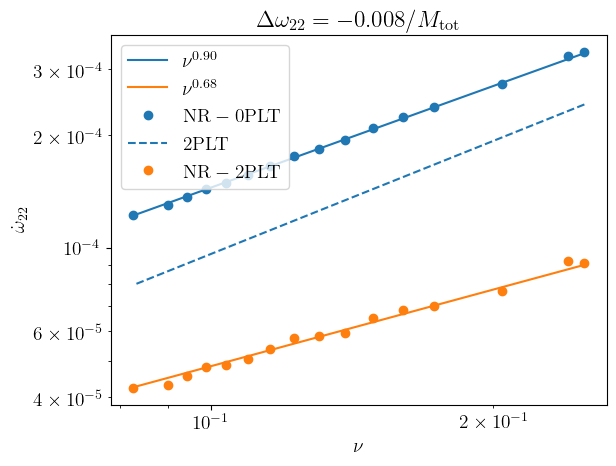

In [61]:
plt.loglog(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRm0PLT),label='$\\nu^{%.2f}$'%coeffsNRm0PLT[1],color='C0')
plt.loglog(nu_vec_true,polynomial_free_2params(nu_vec_true,*coeffsNRm0PLTm2PLT),label='$\\nu^{%.2f}$'%coeffsNRm0PLTm2PLT[1],color='C1')

plt.loglog(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),'o',label='$\mathrm{NR-0PLT}$',color='C0')
plt.loglog(nu_vec_true,np.abs(domegadt2PLT_interp(nu_vec_true)-domegadt0PLT_interp(nu_vec_true)),label='$\mathrm{2PLT}$',color='C0',ls='dashed')
plt.loglog(nu_vec_true,np.abs(domegadtNR_interp(nu_vec_true)-domegadt2PLT_interp(nu_vec_true)),'o',label='$\mathrm{NR-2PLT}$',color='C1')

plt.legend()
plt.xlabel('$\\nu$')
plt.ylabel('$\dot{\omega}_{22}$')
plt.title('$\Delta\omega_{22}=%.03f/M_{\mathrm{tot}}$'%fixed_deltaomega)

## Solving for the GSF phase and frequency

In [62]:
#Functions of Omega
#For comparison with phase and amplitudes
#Note these are domegadt, not dDeltaomegadt as an additional factor of massratiotype(q)**(2/5) has been included.
#Note that dOmegadt is equivalent to domegadt at 0PLT order.

function_dict['omega_evol']={}
function_dict['omega_evol']['dOmegadt_0PLT_evol_Omega']={}
def dOmegadt_0PLT_evol_Omega(t,y,q,massratiotype):
    if (t,tuple(y),q,massratiotype) in function_dict['omega_evol']['dOmegadt_0PLT_evol_Omega']:
        return function_dict['omega_evol']['dOmegadt_0PLT_evol_Omega'][t,tuple(y),q,massratiotype]
    else:
        m=2
        function_dict['omega_evol']['dOmegadt_0PLT_evol_Omega'][t,tuple(y),q,massratiotype]=np.array([(massratiotype(q)**(2/5))*dDeltaOmegadt_0PLT_Omega(np.array([y[0]]),q,massratiotype)[0],y[0]])
        return function_dict['omega_evol']['dOmegadt_0PLT_evol_Omega'][t,tuple(y),q,massratiotype]

function_dict['omega_evol']['domegadt_2PLT_evol_omega']={}
def domegadt_2PLT_reexpanded_evol_omega(t,l,m,y,q,massratiotype):
    if (t,l,m,tuple(y),q,massratiotype) in function_dict['omega_evol']['domegadt_2PLT_evol_omega']:
        return function_dict['omega_evol']['domegadt_2PLT_evol_omega'][t,l,m,tuple(y),q,massratiotype]
    else:
        m=2
        function_dict['omega_evol']['domegadt_2PLT_evol_omega'][t,l,m,tuple(y),q,massratiotype]=np.array([(massratiotype(q)**(2/5))*dDeltaomegadt_2PLT_reexpanded_omega(l,m,np.array([y[0]]),q,massratiotype)[0],y[0]])
        return function_dict['omega_evol']['domegadt_2PLT_evol_omega'][t,l,m,tuple(y),q,massratiotype]

### Integrating backwards and forwards about SXS ISCO time

In [63]:
#Determine time at which ISCO occurs in SXS simulations
def Omegaipos_SXS_omega(sim,N): #approximate position of Omegai in unwrapped frequency vector
    return position(Omegai(),omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)))[0]  #filtered signal does not work here

def tmatchguesstrans_SXS_omega(sim,N): #estimate of time at which Omegainit occurs in NR data
    return tNR_afterjunk_tohorizon(sim)[Omegaipos_SXS_omega(sim,N)]

def frequencymatchtransition_SXS_omega(t): #Includes all times, junk radiation
    N=2
    m=2
    return omegaNR_fourthorder_finitediff(sim,N,t)-Omegai()

def tmatch_phaseatISCO_SXS_omega(sim,N,a,b,tol): #recommend tol=5e-14, a=5, b=5. Guess will be greater than actual value due to the way previous functions are defined.
    if frequencymatchtransition_SXS_omega(tNR_afterjunk_tohorizon(sim))[Omegaipos_SXS_omega(sim,N)]-(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))[Omegaipos_SXS_omega(sim,N)]-Omegai())==0: #Bracket biscetion method doesn't work if guess solution is exact.
        return tmatchguesstrans_SXS_omega(sim,N)
    else:
        return my_bisection(frequencymatchtransition_SXS_omega,tmatchguesstrans_SXS_omega(sim,N)+a,tmatchguesstrans_SXS_omega(sim,N)-b,tol)

In [64]:
#NOTE:
#Even if use DeltaOmegafinal or Omegafinal as critical value, the integrator still goes beyond this value. 
#Need to cut off integration earlier than this.
#The frequency at which the integration should be cut off varies with mass ratio.
#Need to cut off frequency much earlier for q=1000.
#Use Omega_cutoff and DeltaOmega_cutoff as variable in functions.

In [65]:
#Functions of Omega
#For comparison with phase and amplitudes
#Integrate forward and backward from SXS ISCO time calcualted above so that the phases match at the ISCO.
#This works better than integrating forward from some arbitrary time, eg. t=0 and then matching the SXS and GSF frequencies.

function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_backward_omega']={}
def domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,q,massratiotype,omega_cutoff):
    M=1
    if (l,m,q,massratiotype,omega_cutoff) in function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_backward_omega']:
        return function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]
    else:
        def omegacritical(t,y):   
            return y[0]-omega_cutoff
        omegacritical.terminal=True
        function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]=solve_ivp(lambda t, y: domegadt_2PLT_reexpanded_evol_omega(t,l,m,y,q,massratiotype),[0,1000],[Omegai(),unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14))/2],method='LSODA', events=omegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]

function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_forward_omega']={}
def domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,q,massratiotype,omega_cutoff):
    M=1
    if (l,m,q,massratiotype,omega_cutoff) in function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_forward_omega']:
        return function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]
    else: 
        def omegacritical(t,y):   
            return y[0]-omega_cutoff
        omegacritical.terminal=True
        omegacritical.direction=-1
        function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]=solve_ivp(lambda t, y: domegadt_2PLT_reexpanded_evol_omega(t,l,m,y,q,massratiotype),[1000,0],[Omegai(),unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14))/2],method='LSODA', events=omegacritical,teval=np.linspace(100,0,101), dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['domegadt_2PLT_sol_SXSmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]

### Matching SXS and GSF phases

In [66]:
#Note: Integrating the GSF frequency evolution forwards and backwards from the ISCO value of the SXS phase has the best results. 

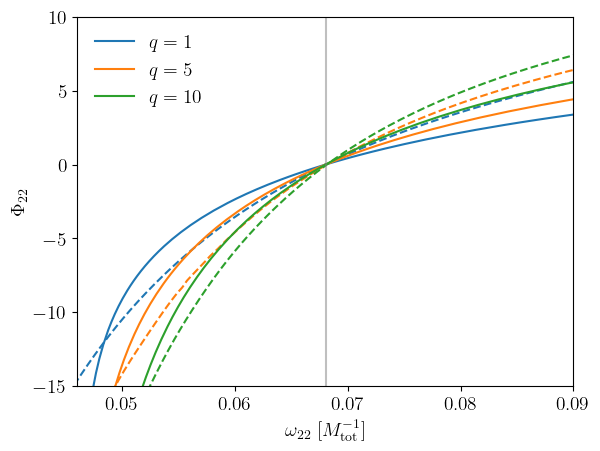

In [67]:
massratiotype=nu
m=2
for sim in np.array([19, 5, 17]): #q=1,5,10
    
    if sim==19:
        colour='C0'
    elif sim==5:
        colour='C1'
    elif sim==17:
        colour='C2'
   
    plt.plot(domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[0],m*domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[1]-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),label='$q=%.0f$'%qNR(sim),color=colour)
    plt.plot(domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[0],m*domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[1]-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),color=colour)
    
    plt.plot(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),unwrappedphaseinterp(sim,N)(tNR_afterjunk_tohorizon(sim))-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),color=colour,ls='dashed')

plt.legend(frameon=False)
plt.ylabel('$\Phi_{22}$')
plt.xlabel('$\omega_{22} ~[M_{\mathrm{tot}}^{-1}]$')

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.xlim(0.046,0.09)
plt.ylim(-15,10)

plt.savefig(f'Final Figures/Phase_omega_SXSsimsv2PLT.png',bbox_inches='tight', dpi=300)

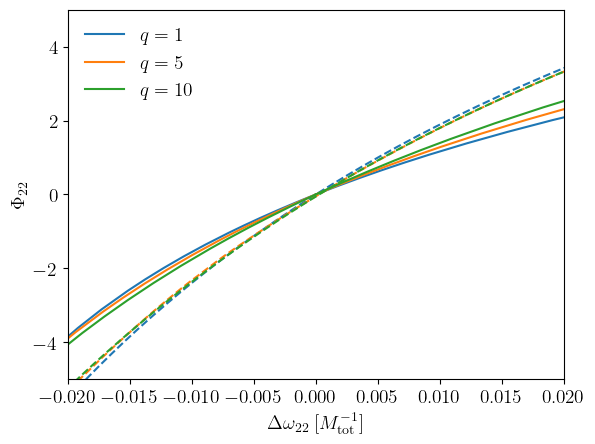

In [157]:
massratiotype=nu
m=2
for sim in np.array([19, 5, 17]): #q=1,5,10
    
    if sim==19:
        colour='C0'
    elif sim==5:
        colour='C1'
    elif sim==17:
        colour='C2'
        
    plt.plot((domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[0]-Omegai())/nu(qNR(sim))**(2/5),m*domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[1]-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),label='$q=%.0f$'%qNR(sim),color=colour)
    plt.plot((domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[0]-Omegai())/nu(qNR(sim))**(2/5),m*domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[1]-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),color=colour)
    
    plt.plot((omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim))-Omegai())/nu(qNR(sim))**(2/5),unwrappedphaseinterp(sim,N)(tNR_afterjunk_tohorizon(sim))-unwrappedphaseinterp(sim,N)(tmatch_phaseatISCO_SXS_omega(sim,N,5,5,5e-14)),color=colour,ls='dashed')

plt.legend(frameon=False)
plt.ylabel('$\Phi_{22}$')
plt.xlabel('$\Delta\omega_{22} ~[M_{\mathrm{tot}}^{-1}]$')

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.xlim(-0.02,0.02)
plt.ylim(-5,5)

plt.savefig(f'Final Figures/Phase_Deltaomega_SXSsimsv2PLT.png',bbox_inches='tight', dpi=300)

### Integrating backwards and forwards about BHPTNRSur ISCO time

In [69]:
#Note: difficult to match phases using frequencies with BHPTNRSur as frequency is not monotonically increasing.

def Omegaipos_phaseNR_0PA_omega(q,l,m): #approximate position of Omegai in unwrapped frequency vector
    return position(Omegai(),omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)))[0] 

def tmatchguesstrans_phaseNR_0PA_omega(q,l,m): #estimate of time at which Omegainit occurs in NR data
    return tNR_0PA_new(q)[Omegaipos_phaseNR_0PA_omega(q,l,m)]

def tmatchtransition_phaseNR_0PA_omega(q,l,m,a,b,tol): 
    def frequencymatchtransition_phaseNR_0PA_omega(t): #Includes all times, junk radiation.
        return omegaNR_secondorder_finitediff_0PA(q,l,m,t)-Omegai()
    if frequencymatchtransition_phaseNR_0PA_omega(tNR_0PA_new(q))[Omegaipos_phaseNR_0PA_omega(q,l,m)]-(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))[Omegaipos_phaseNR_0PA_omega(q,l,m)]-Omegai())==0: #Bracket biscetion method doesn't work if guess solution is exact
        return tmatchguesstrans_phaseNR_0PA_omega(q,l,m)
    else:
        return my_bisection(frequencymatchtransition_phaseNR_0PA_omega,tmatchguesstrans_phaseNR_0PA_omega(q,l,m)+a,tmatchguesstrans_phaseNR_0PA_omega(q,l,m)-b,tol)

In [70]:
#Functions of Omega
#For comparison with phase and amplitudes
#Integrate forward and backward from BHPTNRSur ISCO time calcualted above so that the phases match at the ISCO.
#This works better than integrating forward from some arbitrary time, eg. t=0 and then matching the BHPTNRSur and GSF frequencies.

function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega']={}
def domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,omega_cutoff):
    l=2
    m=2
    M=1
    if (l,m,q,massratiotype,omega_cutoff) in function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega']:
        return function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]
    else:
        def omegacritical(t,y):   
            return y[0]-omega_cutoff
        omegacritical.terminal=True
        function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]=solve_ivp(lambda t, y: domegadt_2PLT_reexpanded_evol_omega(t,l,m,y,q,massratiotype),[0,1000],[Omegai(),unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14))/2],method='LSODA', events=omegacritical, dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega'][l,m,q,massratiotype,omega_cutoff]
    
function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega']={}
def domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,omega_cutoff):
    l=2
    m=2
    M=1
    if (l,m,q,massratiotype,omega_cutoff) in function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega']:
        return function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]
    else:
        def omegacritical(t,y):   
            return y[0]-omega_cutoff
        omegacritical.terminal=True
        omegacritical.direction=-1
        function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]=solve_ivp(lambda t, y: domegadt_2PLT_reexpanded_evol_omega(t,l,m,y,q,massratiotype),[10000,0],[Omegai(),unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14))/2],method='LSODA', events=omegacritical,teval=np.linspace(100,0,101), dense_output=True, rtol = 5e-14)
        return function_dict['omega_evol']['domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega'][l,m,q,massratiotype,omega_cutoff]

### Matching BHPTNRSur and GSF phases

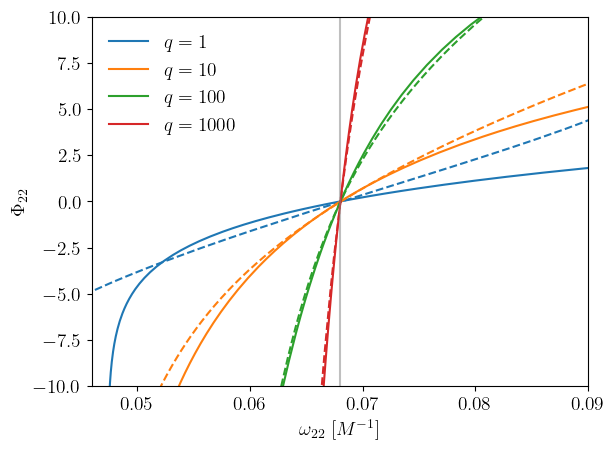

In [113]:
massratiotype=eps

for q in np.array([1, 10, 100, 1000]):
    
    if q==1:
        colour='C0'
    elif q==10:
        colour='C1'
    elif q==100:
        colour='C2'
    elif q==1000:
        colour='C3'
        
    plt.plot(domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[0],2*domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[1]-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)), label='$q=%.0f$'%q,color=colour)
    plt.plot(domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[0],2*domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[1]-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)),color=colour)
      
    plt.plot(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),unwrappedphaseinterp_0PA(q,l,m)(tNR_0PA_new(q))-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)),color=colour,ls='dashed')

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)

plt.xlim(0.046,0.09)
plt.ylim(-10,10)
#plt.yscale('log')
    
plt.legend(frameon=False)
plt.ylabel('$\Phi_{22}$')
plt.xlabel('$\omega_{22} ~[M^{-1}]$')

plt.savefig(f'Final Figures/Phase_omega_BHPTNRSurUncalibratedv2PLT.png',bbox_inches='tight', dpi=300)

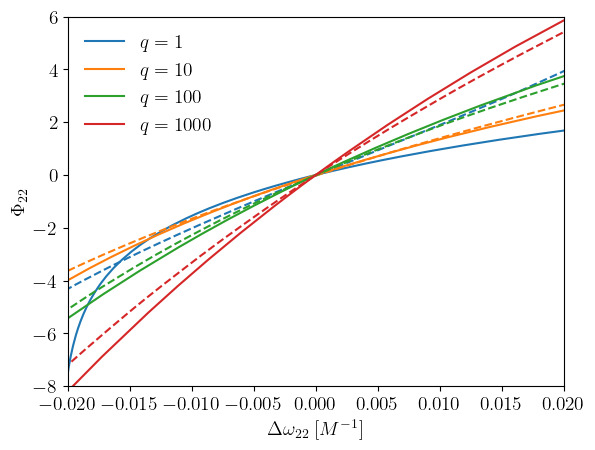

In [158]:
massratiotype=eps

for q in np.array([1, 10, 100, 1000]):
    
    if q==1:
        colour='C0'
    elif q==10:
        colour='C1'
    elif q==100:
        colour='C2'
    elif q==1000:
        colour='C3'
        
    plt.plot((domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[0]-Omegai())/massratiotype(q)**(2/5),2*domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[1]-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)), label='$q=%.0f$'%q,color=colour)
    plt.plot((domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[0]-Omegai())/massratiotype(q)**(2/5),2*domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[1]-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)),color=colour)
      
    plt.plot((omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q))-Omegai())/massratiotype(q)**(2/5),unwrappedphaseinterp_0PA(q,l,m)(tNR_0PA_new(q))-unwrappedphaseinterp_0PA(q,l,m)(tmatchtransition_phaseNR_0PA_omega(q,l,m,5,5,1e-14)),color=colour,ls='dashed')

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)

plt.xlim(-0.02,0.02)
plt.ylim(-8,6)
#plt.yscale('log')
    
plt.legend(frameon=False)
plt.ylabel('$\Phi_{22}$')
plt.xlabel('$\Delta\omega_{22} ~[M^{-1}]$')

plt.savefig(f'Final Figures/Phase_Deltaomega_BHPTNRSurUncalibratedv2PLT.png',bbox_inches='tight', dpi=300)

# GSF Amplitudes (Part II) 

In [72]:
#Functions of omega
def Amp_omega(l,m,omega,q,massratiotype): #Use 0PLT/2PLT solution for Omega for the 0PLT/2PLT amplitude
    return massratiotype(q)*(H5(l,m)+(omega-Omegai())*H7(l,m))

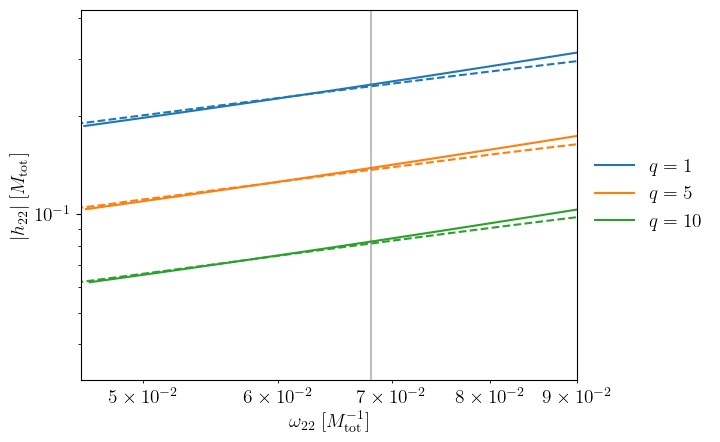

In [134]:
massratiotype=nu
Omega_cutoff=Omegafinal()-0.005

for sim in np.array([19,5,17]): #q=1,5,10
    if sim==19:
        colour='C0'
    elif sim==5:
        colour='C1'
    elif sim==17:
        colour='C2'

    plt.loglog(domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[0],np.abs(Amp_omega(l,m,domegadt_2PLT_sol_SXSmatch_backward_omega(l,m,qNR(sim),massratiotype,0.1).y[0],qNR(sim),massratiotype)),label='$q=%.0f$'%qNR(sim),color=colour)
    plt.loglog(domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[0],np.abs(Amp_omega(l,m,domegadt_2PLT_sol_SXSmatch_forward_omega(l,m,qNR(sim),massratiotype,0.04).y[0],qNR(sim),massratiotype)),color=colour)
    plt.loglog(omegaNR_fourthorder_finitediff(sim,N,tNR_afterjunk_tohorizon(sim)),ampNRinterp(sim,N,tuple(tNR_afterjunk_tohorizon(sim))),color=colour,ls='dashed')

plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
plt.xlabel('$\omega_{22} ~[M_{\mathrm{tot}}^{-1}]$')
plt.ylabel("$|h_{22}| ~[M_{\mathrm{tot}}]$")
plt.xlim(0.046,0.09)
#plt.ylim(0.0,0.32)

plt.savefig(f'Final Figures/Amp_omega_SXSsimsvGSF.png',bbox_inches='tight', dpi=300)

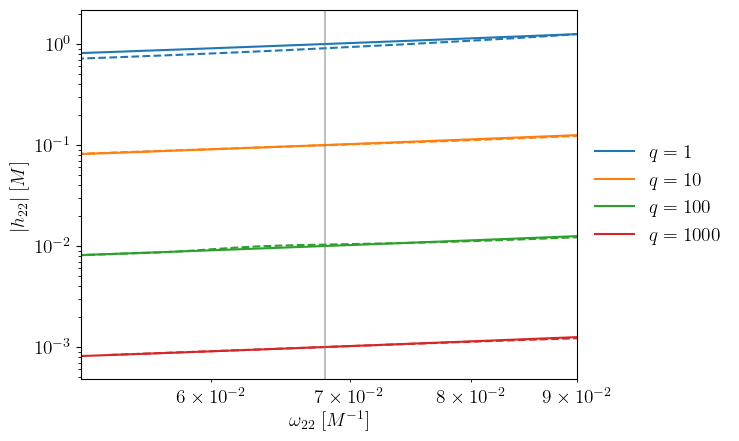

In [135]:
l=2
m=2
massratiotype=eps
for q in np.array([1, 10, 100, 1000]):
    
    if q==1:
        colour='C0'
    elif q==10:
        colour='C1'
    elif q==100:
        colour='C2'
    elif q==1000:
        colour='C3'
        
    plt.loglog(domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[0],np.abs(Amp_omega(l,m,domegadt_2PLT_sol_BHPTNRSurmatch_backward_omega(l,m,q,massratiotype,0.09).y[0],q,massratiotype)), label='$q=%.0f$'%q,color=colour)
    plt.loglog(domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[0],np.abs(Amp_omega(l,m,domegadt_2PLT_sol_BHPTNRSurmatch_forward_omega(l,m,q,massratiotype,0.04).y[0],q,massratiotype)),color=colour)
    plt.loglog(omegaNR_secondorder_finitediff_0PA(q,l,m,tNR_0PA_new(q)),ampNRinterp_0PA(q,l,m,tNR_0PA_new(q)),color=colour,ls='dashed')
    
plt.axvline(x = Omegai(), color = 'gray',alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
plt.xlabel('$\omega_{22} ~[M^{-1}]$')
plt.ylabel('$|h_{22}| ~[M]$')

plt.xlim(0.052,0.09)
#plt.ylim(0,0.5)

plt.savefig(f'Final Figures/Amp_omega_BHPTNRSurUnCalibratedvGSF.png',bbox_inches='tight', dpi=300)